<a href="https://colab.research.google.com/github/bhavinithak/DeepLearning_Pytorch/blob/main/Titanic_NNfromscratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

#Read Kaggle data

In [2]:
creds='{"username":"","key":""}'

In [3]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
path=Path('titanic')

In [5]:
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 3.55MB/s]

In [6]:
!ls {path}

gender_submission.csv  test.csv  train.csv


In [7]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [8]:
df=pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df.shape

(891, 12)

#Data prep

In [10]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
modes=df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [12]:
df.fillna(modes,inplace=True)

In [13]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [14]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

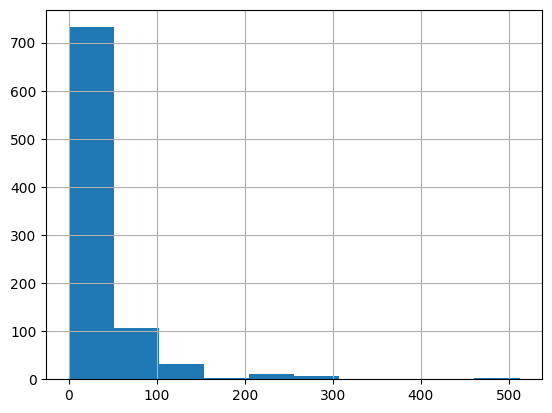

In [15]:
df['Fare'].hist()

In [16]:
df['LogFare']=np.log(df['Fare']+1)

<Axes: >

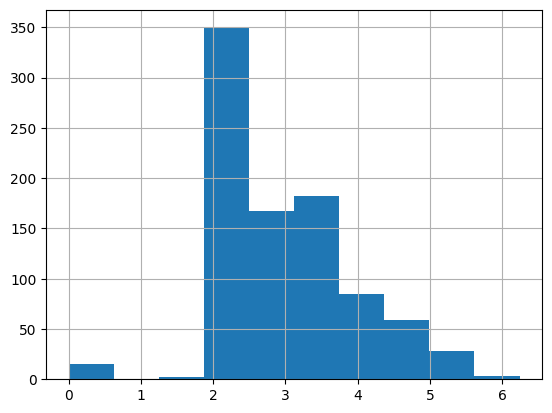

In [17]:
df['LogFare'].hist()

In [18]:
df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [19]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [20]:
df=pd.get_dummies(df, columns=['Sex','Embarked','Pclass'])

In [21]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [22]:
added_columns=['Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
df[added_columns].head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,0,0,1,1,0,0
4,0,1,0,0,1,0,0,1


In [23]:
from torch import tensor

In [24]:
t_dep=tensor(df.Survived)

In [25]:
indep_col=['Age', 'SibSp', 'Parch', 'LogFare'] + added_columns

In [26]:
df[indep_col]

,Age,SibSp,Parch,LogFare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,2.110213,0,1,0,0,1,0,0,1
1,38.0,1,0,4.280593,1,0,1,0,0,1,0,0
2,26.0,0,0,2.188856,1,0,0,0,1,0,0,1
3,35.0,1,0,3.990834,1,0,0,0,1,1,0,0
4,35.0,0,0,2.202765,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,2.639057,0,1,0,0,1,0,1,0
887,19.0,0,0,3.433987,1,0,0,0,1,1,0,0
888,24.0,1,2,3.196630,1,0,0,0,1,0,0,1
889,26.0,0,0,3.433987,0,1,1,0,0,1,0,0


In [27]:
t_indep=tensor(df[indep_col].values.astype('float64'),dtype=torch.float)

In [28]:
t_indep.shape

torch.Size([891, 12])

#Setting up a linear model

In [29]:
torch.manual_seed(442)

In [30]:
n_coeff=t_indep.shape[1]
coeffs=torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [31]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.4392,   0.0000,   0.0000],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.3147,   0.0000,   0.3136,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.4392,   0.0000,   0.0000],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.0000,  -0.3147,   0.0000

In [32]:
vals, indices = t_indep.max(dim=0)
t_indep =t_indep/vals

In [33]:
t_indep

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.3375, 0.0000, 0.0000, 

In [34]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.4392,  0.0000,  0.0000],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.0000, -0.3147,  0.0000,  0.3136,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.4392,  0.0000,  0.0000],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [35]:
preds=(t_indep*coeffs).sum(axis=1)

In [36]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494, -0.7523,  0.0453,  0.1411, -0.9302,  0.2961,  0.2128,  0.2464])

In [37]:
loss=torch.abs(preds-t_dep).mean()
loss

tensor(0.6020)

In [38]:
def calc_preds(coeffs,t_indep):
  return (t_indep*coeffs).sum(axis=1)

In [39]:
def calc_loss(coeffs,t_indep,t_dep):
  return torch.abs(calc_preds(coeffs,t_indep)-t_dep).mean()

#Gradient descent

In [40]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [41]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.6020, grad_fn=<MeanBackward0>)

In [42]:
loss.backward()

In [43]:
coeffs.grad

tensor([-0.1019,  0.0070, -0.0082, -0.1458, -0.1886,  0.0191, -0.0786,  0.0101, -0.1010, -0.2424, -0.1706,  0.2435])

In [44]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5576)


#Training linear model

In [45]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [46]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [47]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [48]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [49]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [50]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [51]:
coeffs = train_model(18, lr=0.2)

0.598; 0.554; 0.518; 0.485; 0.456; 0.429; 0.404; 0.381; 0.368; 0.366; 0.327; 0.313; 0.311; 0.303; 0.303; 0.289; 0.284; 0.282; 

In [52]:
def show_coeffs(): return dict(zip(indep_col, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2313),
 'SibSp': tensor(0.0923),
 'Parch': tensor(0.2388),
 'LogFare': tensor(0.0857),
 'Sex_female': tensor(0.2781),
 'Sex_male': tensor(-0.4696),
 'Embarked_C': tensor(0.5987),
 'Embarked_Q': tensor(0.3871),
 'Embarked_S': tensor(0.4818),
 'Pclass_1': tensor(0.1880),
 'Pclass_2': tensor(0.2299),
 'Pclass_3': tensor(0.1022)}

#Measuring Accuracy

In [53]:
preds = calc_preds(coeffs, val_indep)

In [54]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [55]:
results.float().mean()

tensor(0.7921)

In [56]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7921)

# Using Sigmoid

In [57]:
preds[:28] #preds are less than 0 and greater than 1 so we pass them thru sigmoid function

tensor([ 0.8613, -0.0199,  0.1909,  0.2494,  0.2062,  0.1979,  1.0439,  0.9452,  0.3020,  1.0042,  0.0520,  0.2515,  0.1885,  0.7280,
         0.0438,  0.1157,  0.0579,  1.0027,  0.1747,  0.8037,  0.0751,  0.0839,  1.0682,  0.9997,  0.0853,  0.0061,  0.9449,  0.0666])

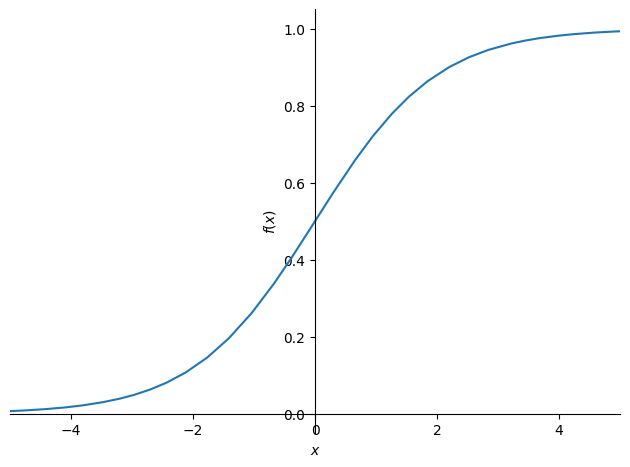

In [58]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [59]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))


In [60]:
coeffs = train_model(lr=100)

0.513; 0.330; 0.319; 0.268; 0.205; 0.200; 0.198; 0.197; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [61]:
acc(coeffs)

tensor(0.8258)

In [62]:
show_coeffs()

{'Age': tensor(-1.4444),
 'SibSp': tensor(-1.1728),
 'Parch': tensor(-0.5275),
 'LogFare': tensor(0.3396),
 'Sex_female': tensor(8.4492),
 'Sex_male': tensor(-10.3604),
 'Embarked_C': tensor(2.0658),
 'Embarked_Q': tensor(2.3102),
 'Embarked_S': tensor(-4.6281),
 'Pclass_1': tensor(3.1634),
 'Pclass_2': tensor(2.2232),
 'Pclass_3': tensor(-6.5861)}

#Test data

In [63]:
tst_df = pd.read_csv(path/'test.csv')

In [64]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [65]:
tst_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [66]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_col].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [67]:
tst_df['Survived'] = (calc_preds(coeffs,tst_indep)>0.5).int()


# Neural Network

In [68]:
val_indep.shape

torch.Size([178, 12])

In [69]:
coeffs.shape

torch.Size([12])

In [70]:
coeffs

tensor([ -1.4444,  -1.1728,  -0.5275,   0.3396,   8.4492, -10.3604,   2.0658,   2.3102,  -4.6281,   3.1634,   2.2232,  -6.5861])

In [71]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [72]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [73]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [74]:
coeffs = train_model(lr=100)

0.513; 0.323; 0.293; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [75]:
acc(coeffs)

tensor(0.8258)

#Deep Learning

In [76]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [77]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [78]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [79]:
coeffs = train_model(lr=4)


0.512; 0.483; 0.469; 0.456; 0.445; 0.404; 0.378; 0.378; 0.378; 0.377; 0.376; 0.373; 0.352; 0.245; 0.236; 0.211; 0.213; 0.206; 0.200; 0.199; 0.198; 0.196; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.193; 

In [80]:
acc(coeffs)


tensor(0.8258)